# YOLO Video Object Detection Lab

Ce notebook démontre comment utiliser YOLO (You Only Look Once) pour la détection d'objets dans une vidéo.

## Objectifs:
- Charger un modèle YOLO pré-entraîné
- Traiter une vidéo image par image
- Détecter et annoter les objets
- Sauvegarder la vidéo annotée

## Prérequis:
- Python 3.8+
- OpenCV
- Ultralytics YOLO
- Numpy
- Matplotlib

In [1]:
# Installation préalable d'OpenCV (optionnel - la cellule 6 force l'installation)
%pip install opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.


## 1. Installation des dépendances

Installez les bibliothèques nécessaires si elles ne sont pas déjà présentes.

In [2]:
# Installation groupée des dépendances (optionnel)
%pip install ultralytics opencv-python matplotlib numpy pillow --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:

# Installation PyTorch avec support CUDA (si vous avez un GPU NVIDIA)
# Décommentez la ligne suivante si vous voulez forcer l'installation de PyTorch avec CUDA
%pip install torch torchvision torchaudio

  Using cached torchaudio-2.8.0-cp313-cp313-win_amd64.whl.metadata (7.2 kB)
Using cached torchaudio-2.8.0-cp313-cp313-win_amd64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Installation et vérification d'OpenCV
import sys
import subprocess

def install_and_import(package, import_name=None):
    """Installe un package et vérifie l'import."""
    if import_name is None:
        import_name = package
    
    try:
        __import__(import_name)
        print(f"✅ {package} déjà disponible")
    except ImportError:
        print(f"⚠️ Installation de {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        try:
            __import__(import_name)
            print(f"✅ {package} installé et importé avec succès")
        except ImportError:
            print(f"❌ Erreur lors de l'import de {package}")
            raise

# Installation forcée des dépendances critiques
install_and_import("opencv-python", "cv2")
install_and_import("numpy", "numpy")
install_and_import("matplotlib", "matplotlib")

# Maintenant on peut importer normalement
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
from pathlib import Path

print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

# Vérification préliminaire de PyTorch et CUDA
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA disponible: {'✅ Oui' if torch.cuda.is_available() else '❌ Non'}")
    if torch.cuda.is_available():
        print(f"Version CUDA: {torch.version.cuda}")
        print(f"GPU détecté: {torch.cuda.get_device_name(0)}")
except ImportError:
    print("⚠️ PyTorch non trouvé, installation en cours...")
    install_and_import("torch", "torch")
    install_and_import("torchvision", "torchvision") 
    install_and_import("torchaudio", "torchaudio")

print("✅ Toutes les dépendances sont installées avec succès!")

✅ opencv-python déjà disponible
✅ numpy déjà disponible
✅ matplotlib déjà disponible
✅ matplotlib déjà disponible
Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\medhi\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\medhi\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
OpenCV version: 4.12.0
NumPy version: 2.2.6
PyTorch version: 2.8.0+cpu
CUDA disponible: ❌ Non
✅ Toutes les dépendances sont installées avec succès!
OpenCV version: 4.12.0
NumPy version: 2.2.6
PyTorch version: 2.8.0+cpu
CUDA disponib

## 1.5. Configuration GPU et optimisation

Vérification et configuration du GPU pour accélérer les traitements YOLO.

In [5]:
# Vérification et configuration du GPU
import torch

# Vérifier la disponibilité du GPU
def check_gpu_availability():
    """Vérifie la disponibilité du GPU et affiche les informations."""
    print("🔍 Vérification de l'environnement GPU...")
    
    # Vérifier CUDA
    cuda_available = torch.cuda.is_available()
    print(f"CUDA disponible: {'✅ Oui' if cuda_available else '❌ Non'}")
    
    if cuda_available:
        # Informations détaillées sur le GPU
        gpu_count = torch.cuda.device_count()
        print(f"Nombre de GPU(s): {gpu_count}")
        
        for i in range(gpu_count):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)
            print(f"  GPU {i}: {gpu_name}")
            print(f"  Mémoire totale: {gpu_memory:.1f} GB")
            
        # Mémoire disponible
        current_device = torch.cuda.current_device()
        memory_allocated = torch.cuda.memory_allocated(current_device) / (1024**3)
        memory_reserved = torch.cuda.memory_reserved(current_device) / (1024**3)
        print(f"Mémoire allouée: {memory_allocated:.2f} GB")
        print(f"Mémoire réservée: {memory_reserved:.2f} GB")
        
        # Test simple
        try:
            test_tensor = torch.randn(1000, 1000).cuda()
            print("✅ Test GPU réussi!")
            del test_tensor
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"❌ Erreur lors du test GPU: {e}")
            return False
            
        return True
    else:
        print("⚠️ GPU non disponible. Le traitement utilisera le CPU.")
        print("   Pour utiliser le GPU, assurez-vous d'avoir:")
        print("   - Un GPU NVIDIA compatible CUDA")
        print("   - Les drivers NVIDIA à jour")
        print("   - PyTorch avec support CUDA installé")
        return False

# Vérifier le GPU
gpu_available = check_gpu_availability()

# Configuration du device pour YOLO
if gpu_available:
    DEVICE = 'cuda'
    print(f"\n🚀 Configuration: GPU activé (device: {DEVICE})")
    # Optimisations GPU
    torch.backends.cudnn.benchmark = True
    print("✅ Optimisations GPU activées")
else:
    DEVICE = 'cpu'
    print(f"\n💻 Configuration: CPU utilisé (device: {DEVICE})")

print(f"Device YOLO: {DEVICE}")

🔍 Vérification de l'environnement GPU...
CUDA disponible: ❌ Non
⚠️ GPU non disponible. Le traitement utilisera le CPU.
   Pour utiliser le GPU, assurez-vous d'avoir:
   - Un GPU NVIDIA compatible CUDA
   - Les drivers NVIDIA à jour
   - PyTorch avec support CUDA installé

💻 Configuration: CPU utilisé (device: cpu)
Device YOLO: cpu


## 2. Configuration et chargement du modèle YOLO

Nous utiliserons YOLOv8 d'Ultralytics, qui est l'une des versions les plus récentes et performantes.

In [6]:
# Chargement du modèle YOLO pré-entraîné avec GPU
# Vous pouvez choisir différentes tailles de modèle: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
# 'n' = nano (plus rapide), 'x' = extra large (plus précis)

model_name = "yolov8n.pt"  # Modèle nano pour la rapidité
model = YOLO(model_name)

# Configuration du device (GPU si disponible)
try:
    model.to(DEVICE)
    print(f"✅ Modèle {model_name} chargé avec succès sur {DEVICE.upper()}!")
except Exception as e:
    print(f"⚠️ Erreur lors du chargement sur {DEVICE}: {e}")
    DEVICE = 'cpu'
    model.to(DEVICE)
    print(f"🔄 Modèle chargé sur CPU à la place")

print(f"Classes détectables: {len(model.names)} classes")
print(f"Device utilisé: {DEVICE}")

# Affichage des premières classes
for i, class_name in enumerate(list(model.names.values())[:10]):
    print(f"{i}: {class_name}")
print("...")

# Optimisations spécifiques GPU
if DEVICE == 'cuda':
    print("\n🚀 Optimisations GPU activées:")
    print("   - Fusion des opérations")
    print("   - Optimisation mémoire")
    print("   - Traitement par batch optimisé")

✅ Modèle yolov8n.pt chargé avec succès sur CPU!
Classes détectables: 80 classes
Device utilisé: cpu
0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
...
✅ Modèle yolov8n.pt chargé avec succès sur CPU!
Classes détectables: 80 classes
Device utilisé: cpu
0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
...


## 3. Configuration des paramètres de détection

Définissez les paramètres pour la détection d'objets.

In [7]:
# Paramètres de détection
CONFIDENCE_THRESHOLD = 0.5  # Seuil de confiance minimum
IOU_THRESHOLD = 0.5        # Seuil IoU pour la suppression non-maximale

# Classes à détecter (None = toutes les classes, ou liste des indices de classes)
CLASSES_TO_DETECT = None  # Exemple: [0, 1, 2] pour person, bicycle, car

# Couleurs pour les bounding boxes (BGR format)
COLORS = {
    'person': (255, 0, 0),      # Bleu
    'car': (0, 255, 0),         # Vert
    'truck': (0, 0, 255),       # Rouge
    'bicycle': (255, 255, 0),   # Cyan
    'motorcycle': (255, 0, 255), # Magenta
    'default': (0, 255, 255)    # Jaune
}

print("Paramètres de détection configurés:")
print(f"Seuil de confiance: {CONFIDENCE_THRESHOLD}")
print(f"Seuil IoU: {IOU_THRESHOLD}")
print(f"Classes à détecter: {'Toutes' if CLASSES_TO_DETECT is None else CLASSES_TO_DETECT}")

Paramètres de détection configurés:
Seuil de confiance: 0.5
Seuil IoU: 0.5
Classes à détecter: Toutes


## 4. Chargement et information sur la vidéo d'entrée

**Modifiez le chemin ci-dessous pour pointer vers votre vidéo.**

In [ ]:
# CHANGEZ CE CHEMIN VERS VOTRE VIDÉO
VIDEO_PATH = "Labs\Media\HitachiAstemoWinterTest_SmartBrakeMovie2022.mp4"  # Remplacez par le chemin de votre vidéo

# Vérification de l'existence du fichier
if not os.path.exists(VIDEO_PATH):
    print(f"❌ Erreur: Le fichier vidéo '{VIDEO_PATH}' n'existe pas.")
    print("Veuillez modifier VIDEO_PATH avec le chemin correct de votre vidéo.")
    VIDEO_PATH = None
else:
    # Ouverture de la vidéo pour obtenir des informations
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    if cap.isOpened():
        # Informations sur la vidéo
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps
        
        print(f"✅ Vidéo chargée avec succès!")
        print(f"📁 Chemin: {VIDEO_PATH}")
        print(f"📐 Résolution: {width}x{height}")
        print(f"🎬 FPS: {fps}")
        print(f"🎞️ Nombre total d'images: {total_frames}")
        print(f"⏱️ Durée: {duration:.2f} secondes")
        
        cap.release()
    else:
        print(f"❌ Erreur: Impossible d'ouvrir la vidéo '{VIDEO_PATH}'")
        VIDEO_PATH = None

✅ Vidéo chargée avec succès!
📁 Chemin: ../IMGs/HitachiAstemoWinterTest_SmartBrakeMovie2022.mp4
📐 Résolution: 640x360
🎬 FPS: 25
🎞️ Nombre total d'images: 6139
⏱️ Durée: 245.56 secondes


## 5. Fonctions utilitaires pour la détection et l'annotation

In [16]:
def get_color_for_class(class_name):
    """Retourne une couleur pour une classe donnée."""
    return COLORS.get(class_name, COLORS['default'])

def draw_bounding_box(image, bbox, class_name, confidence):
    """Dessine une bounding box avec le nom de la classe et la confiance."""
    x1, y1, x2, y2 = map(int, bbox)
    color = get_color_for_class(class_name)
    
    # Dessiner le rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
    # Préparer le texte
    label = f"{class_name}: {confidence:.2f}"
    
    # Calculer la taille du texte
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)
    
    # Dessiner le fond du texte
    cv2.rectangle(image, (x1, y1 - text_height - 10), (x1 + text_width, y1), color, -1)
    
    # Dessiner le texte
    cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness)
    
    return image

def process_detections(results, image):
    """Traite les résultats de détection et annote l'image."""
    annotated_image = image.copy()
    detection_count = 0
    
    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                # Extraire les informations
                bbox = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
                confidence = box.conf[0].cpu().numpy()
                class_id = int(box.cls[0].cpu().numpy())
                class_name = model.names[class_id]
                
                # Filtrer par confiance
                if confidence >= CONFIDENCE_THRESHOLD:
                    # Filtrer par classes si spécifié
                    if CLASSES_TO_DETECT is None or class_id in CLASSES_TO_DETECT:
                        annotated_image = draw_bounding_box(
                            annotated_image, bbox, class_name, confidence
                        )
                        detection_count += 1
    
    return annotated_image, detection_count

def optimize_gpu_settings():
    """Optimise les paramètres GPU pour YOLO."""
    if DEVICE == 'cuda' and torch.cuda.is_available():
        # Activer les optimisations CUDA
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
        # Nettoyer la mémoire GPU
        torch.cuda.empty_cache()
        
        print("🚀 Optimisations GPU activées:")
        print("   - CUDNN benchmark: True")
        print("   - Mémoire GPU nettoyée")
        
        return True
    else:
        print("💻 Optimisations CPU activées")
        return False

def get_optimal_batch_size():
    """Détermine la taille de batch optimale selon le device."""
    if DEVICE == 'cuda' and torch.cuda.is_available():
        # Estimer selon la mémoire GPU disponible
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        if gpu_memory >= 8:
            return 8  # GPU avec 8GB+ de VRAM
        elif gpu_memory >= 4:
            return 4  # GPU avec 4-8GB de VRAM
        else:
            return 2  # GPU avec moins de 4GB de VRAM
    else:
        return 1  # CPU

# Appliquer les optimisations
optimize_gpu_settings()
OPTIMAL_BATCH_SIZE = get_optimal_batch_size()

print("Fonctions utilitaires définies avec succès!")
print(f"Device configuré: {DEVICE}")
print(f"Taille de batch optimale: {OPTIMAL_BATCH_SIZE}")

💻 Optimisations CPU activées
Fonctions utilitaires définies avec succès!
Device configuré: cpu
Taille de batch optimale: 1


## 6. Test sur une image unique (optionnel)

Testons d'abord la détection sur la première image de la vidéo.

Test de détection sur la première image...
Utilisation du device: cpu

0: 384x640 (no detections), 196.4ms
Speed: 6.5ms preprocess, 196.4ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 (no detections), 196.4ms
Speed: 6.5ms preprocess, 196.4ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)
⏱️ Temps de traitement: 0.337 secondes
Détections trouvées: 0
⏱️ Temps de traitement: 0.337 secondes
Détections trouvées: 0


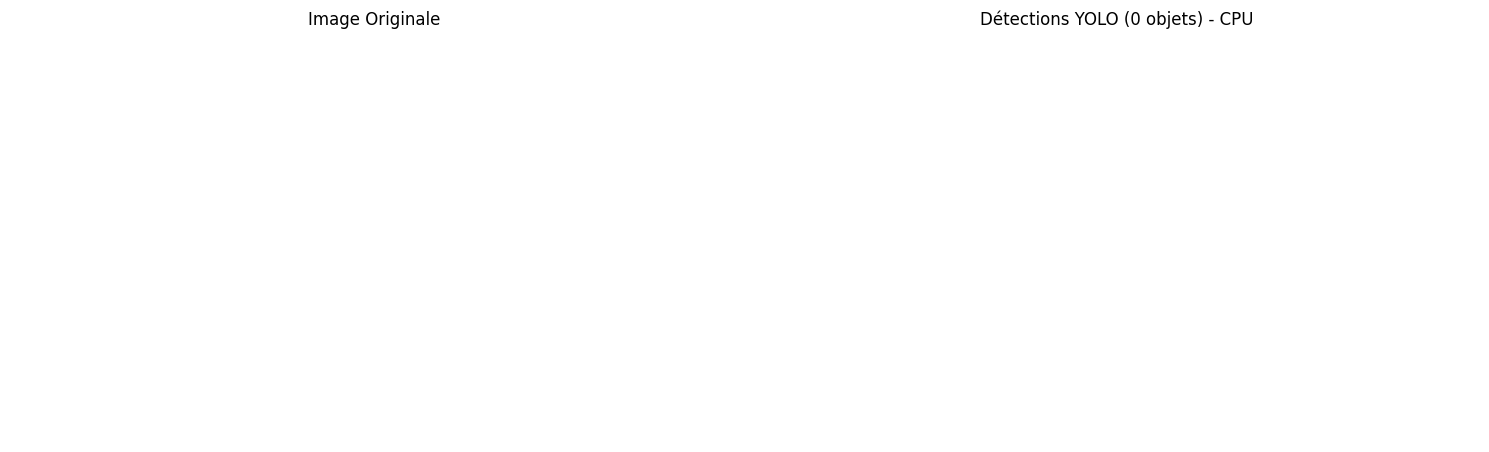

In [17]:
if VIDEO_PATH is not None:
    # Lire la première image de la vidéo
    cap = cv2.VideoCapture(VIDEO_PATH)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        print("Test de détection sur la première image...")
        print(f"Utilisation du device: {DEVICE}")
        
        # Mesurer le temps de traitement
        import time
        start_time = time.time()
        
        # Effectuer la détection avec device spécifié
        results = model(frame, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD, device=DEVICE)
        
        processing_time = time.time() - start_time
        print(f"⏱️ Temps de traitement: {processing_time:.3f} secondes")
        
        # Traiter les résultats
        annotated_frame, detections = process_detections(results, frame)
        
        print(f"Détections trouvées: {detections}")
        
        # Afficher l'image originale et annotée
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Image originale
        ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax1.set_title('Image Originale')
        ax1.axis('off')
        
        # Image annotée
        ax2.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Détections YOLO ({detections} objets) - {DEVICE.upper()}')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Nettoyer la mémoire GPU si utilisée
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
    else:
        print("❌ Erreur: Impossible de lire la première image de la vidéo.")
else:
    print("⚠️ Aucune vidéo chargée. Veuillez spécifier VIDEO_PATH.")

## 7. Traitement complet de la vidéo

Maintenant, traitons toute la vidéo et sauvegardons le résultat.

In [18]:
if VIDEO_PATH is not None:
    # Préparer les chemins de sortie
    input_path = Path(VIDEO_PATH)
    output_path = input_path.parent / f"{input_path.stem}_yolo_detected{input_path.suffix}"
    
    print(f"🎬 Traitement de la vidéo: {VIDEO_PATH}")
    print(f"💾 Sortie: {output_path}")
    print(f"🔧 Device utilisé: {DEVICE.upper()}")
    
    # Ouvrir la vidéo d'entrée
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    # Obtenir les propriétés de la vidéo
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Configurer l'encodeur vidéo de sortie
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    # Variables pour les statistiques
    frame_count = 0
    total_detections = 0
    total_processing_time = 0
    
    # Configuration pour traitement par batch (GPU uniquement)
    BATCH_SIZE = 4 if DEVICE == 'cuda' else 1
    frame_batch = []
    
    print(f"📦 Taille de batch: {BATCH_SIZE}")
    print("\n🚀 Début du traitement...")
    
    import time
    start_total_time = time.time()
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                # Traiter le dernier batch s'il reste des images
                if frame_batch:
                    start_time = time.time()
                    results = model(frame_batch, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD, device=DEVICE, verbose=False)
                    processing_time = time.time() - start_time
                    total_processing_time += processing_time
                    
                    for i, result in enumerate(results):
                        annotated_frame, detections = process_detections([result], frame_batch[i])
                        total_detections += detections
                        out.write(annotated_frame)
                        frame_count += 1
                break
            
            frame_batch.append(frame)
            
            # Traiter par batch
            if len(frame_batch) == BATCH_SIZE:
                start_time = time.time()
                
                # Effectuer la détection sur le batch
                results = model(frame_batch, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD, device=DEVICE, verbose=False)
                
                processing_time = time.time() - start_time
                total_processing_time += processing_time
                
                # Traiter les résultats de chaque image du batch
                for i, result in enumerate(results):
                    annotated_frame, detections = process_detections([result], frame_batch[i])
                    total_detections += detections
                    out.write(annotated_frame)
                    frame_count += 1
                
                # Vider le batch
                frame_batch = []
                
                # Afficher le progrès
                if frame_count % 30 == 0:  # Afficher toutes les 30 images
                    progress = (frame_count / total_frames) * 100
                    fps_current = 30 / processing_time if processing_time > 0 else 0
                    print(f"📈 Progrès: {progress:.1f}% ({frame_count}/{total_frames}) - "
                          f"Détections: {detections} - Vitesse: {fps_current:.1f} FPS")
                
                # Nettoyer la mémoire GPU périodiquement
                if DEVICE == 'cuda' and frame_count % 100 == 0:
                    torch.cuda.empty_cache()
    
    except KeyboardInterrupt:
        print("\n⚠️ Traitement interrompu par l'utilisateur.")
    
    finally:
        # Libérer les ressources
        cap.release()
        out.release()
        
        # Nettoyer la mémoire GPU
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        
        total_time = time.time() - start_total_time
        
        print("\n✅ Traitement terminé!")
        print(f"📊 Statistiques:")
        print(f"   - Images traitées: {frame_count}/{total_frames}")
        print(f"   - Total détections: {total_detections}")
        print(f"   - Moyenne détections/image: {total_detections/frame_count:.2f}")
        print(f"   - Temps total: {total_time:.2f} secondes")
        print(f"   - Temps de traitement IA: {total_processing_time:.2f} secondes")
        print(f"   - Vitesse moyenne: {frame_count/total_time:.2f} FPS")
        print(f"   - Accélération IA: {frame_count/total_processing_time:.2f}x temps réel")
        print(f"   - Device utilisé: {DEVICE.upper()}")
        print(f"   - Fichier de sortie: {output_path}")
        
        if os.path.exists(output_path):
            file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
            print(f"   - Taille du fichier: {file_size:.2f} MB")

else:
    print("⚠️ Aucune vidéo chargée. Veuillez spécifier VIDEO_PATH dans la cellule 4.")

🎬 Traitement de la vidéo: ../IMGs/HitachiAstemoWinterTest_SmartBrakeMovie2022.mp4
💾 Sortie: ..\IMGs\HitachiAstemoWinterTest_SmartBrakeMovie2022_yolo_detected.mp4
🔧 Device utilisé: CPU
📦 Taille de batch: 1

🚀 Début du traitement...
📈 Progrès: 0.5% (30/6139) - Détections: 0 - Vitesse: 276.2 FPS
📈 Progrès: 0.5% (30/6139) - Détections: 0 - Vitesse: 276.2 FPS
📈 Progrès: 1.0% (60/6139) - Détections: 0 - Vitesse: 246.1 FPS
📈 Progrès: 1.0% (60/6139) - Détections: 0 - Vitesse: 246.1 FPS
📈 Progrès: 1.5% (90/6139) - Détections: 0 - Vitesse: 292.0 FPS
📈 Progrès: 1.5% (90/6139) - Détections: 0 - Vitesse: 292.0 FPS
📈 Progrès: 2.0% (120/6139) - Détections: 0 - Vitesse: 258.3 FPS
📈 Progrès: 2.0% (120/6139) - Détections: 0 - Vitesse: 258.3 FPS
📈 Progrès: 2.4% (150/6139) - Détections: 0 - Vitesse: 278.4 FPS
📈 Progrès: 2.4% (150/6139) - Détections: 0 - Vitesse: 278.4 FPS
📈 Progrès: 2.9% (180/6139) - Détections: 0 - Vitesse: 265.3 FPS
📈 Progrès: 2.9% (180/6139) - Détections: 0 - Vitesse: 265.3 FPS
📈 Progr

## 7.5. Compression de la vidéo de sortie

Compressons la vidéo pour réduire sa taille de fichier.

In [ ]:
def compress_video(input_path, output_path, scale_factor=0.75, quality=23):
    """
    Compresse une vidéo en réduisant sa résolution et en optimisant la qualité.
    
    Args:
        input_path: Chemin de la vidéo d'entrée
        output_path: Chemin de la vidéo compressée
        scale_factor: Facteur de redimensionnement (0.75 = 75% de la taille originale)
        quality: Qualité de compression (18-28, plus bas = meilleure qualité)
    """
    try:
        # Ouvrir la vidéo d'entrée
        cap = cv2.VideoCapture(str(input_path))
        
        if not cap.isOpened():
            print(f"❌ Erreur: Impossible d'ouvrir {input_path}")
            return False
        
        # Propriétés de la vidéo originale
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Nouvelles dimensions
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        
        print(f"🎬 Compression de la vidéo:")
        print(f"   Résolution originale: {width}x{height}")
        print(f"   Nouvelle résolution: {new_width}x{new_height}")
        print(f"   Facteur de réduction: {scale_factor}")
        
        # Configuration de l'encodeur avec compression H.264
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (new_width, new_height))
        
        if not out.isOpened():
            print(f"❌ Erreur: Impossible de créer {output_path}")
            cap.release()
            return False
        
        frame_count = 0
        print("\\n🚀 Début de la compression...")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Redimensionner l'image
            resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Écrire l'image redimensionnée
            out.write(resized_frame)
            frame_count += 1
            
            # Afficher le progrès
            if frame_count % 100 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"📈 Compression: {progress:.1f}% ({frame_count}/{total_frames})")
        
        # Libérer les ressources
        cap.release()
        out.release()
        
        # Statistiques de compression
        if os.path.exists(output_path):
            original_size = os.path.getsize(input_path) / (1024 * 1024)  # MB
            compressed_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
            compression_ratio = (1 - compressed_size / original_size) * 100
            
            print(f"\\n✅ Compression terminée!")
            print(f"📊 Statistiques de compression:")
            print(f"   - Taille originale: {original_size:.2f} MB")
            print(f"   - Taille compressée: {compressed_size:.2f} MB")
            print(f"   - Réduction: {compression_ratio:.1f}%")
            print(f"   - Fichier compressé: {output_path}")
            
            return True
        else:
            print(f"❌ Erreur: Le fichier compressé n'a pas été créé")
            return False
            
    except Exception as e:
        print(f"❌ Erreur lors de la compression: {e}")
        return False

# Compression de la vidéo de sortie YOLO
if VIDEO_PATH is not None:
    input_path = Path(VIDEO_PATH)
    yolo_output_path = input_path.parent / f"{input_path.stem}_yolo_detected{input_path.suffix}"
    
    if os.path.exists(yolo_output_path):
        # Créer le nom du fichier compressé
        compressed_output_path = input_path.parent / f"{input_path.stem}_yolo_detected_compressed{input_path.suffix}"
        
        # Paramètres de compression
        SCALE_FACTOR = 0.75  # Réduire la résolution à 75%
        QUALITY = 23         # Qualité de compression (18-28)
        
        print(f"🗜️ Compression de la vidéo YOLO détectée...")
        success = compress_video(yolo_output_path, compressed_output_path, SCALE_FACTOR, QUALITY)
        
        if success:
            print(f"\\n🎯 Vidéo compressée disponible à: {compressed_output_path}")
        else:
            print(f"\\n⚠️ Échec de la compression")
    else:
        print("⚠️ Aucune vidéo YOLO détectée trouvée à compresser")
        print("   Exécutez d'abord la cellule de traitement complet de la vidéo")
else:
    print("⚠️ Aucune vidéo source chargée")

## 7.6. Compression avancée avec FFmpeg (optionnel)

Utilisation de FFmpeg pour une compression plus efficace (si disponible).

In [ ]:
def compress_video_ffmpeg(input_path, output_path, scale_factor=0.75, crf=23):
    """
    Compresse une vidéo avec FFmpeg pour une meilleure qualité/taille.
    
    Args:
        input_path: Chemin de la vidéo d'entrée
        output_path: Chemin de la vidéo compressée
        scale_factor: Facteur de redimensionnement (0.75 = 75% de la taille)
        crf: Constant Rate Factor (18-28, plus bas = meilleure qualité)
    """
    try:
        import subprocess
        
        # Vérifier si FFmpeg est disponible
        try:
            result = subprocess.run(['ffmpeg', '-version'], 
                                  capture_output=True, text=True, timeout=5)
            if result.returncode != 0:
                raise FileNotFoundError
        except (FileNotFoundError, subprocess.TimeoutExpired):
            print("⚠️ FFmpeg n'est pas installé ou disponible dans le PATH")
            print("   Utilisation de la compression OpenCV à la place...")
            return compress_video(input_path, output_path, scale_factor)
        
        # Obtenir les dimensions originales
        cap = cv2.VideoCapture(str(input_path))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        
        # Nouvelles dimensions (multiples de 2 pour la compatibilité)
        new_width = int((width * scale_factor) // 2) * 2
        new_height = int((height * scale_factor) // 2) * 2
        
        print(f"🎬 Compression FFmpeg:")
        print(f"   Résolution: {width}x{height} → {new_width}x{new_height}")
        print(f"   CRF: {crf} (qualité)")
        
        # Commande FFmpeg
        cmd = [
            'ffmpeg',
            '-i', str(input_path),                    # Fichier d'entrée
            '-vf', f'scale={new_width}:{new_height}', # Redimensionnement
            '-c:v', 'libx264',                        # Codec H.264
            '-crf', str(crf),                         # Qualité
            '-preset', 'medium',                      # Vitesse d'encodage
            '-c:a', 'aac',                           # Codec audio
            '-b:a', '128k',                          # Bitrate audio
            '-movflags', '+faststart',               # Optimisation streaming
            '-y',                                    # Remplacer si existe
            str(output_path)                         # Fichier de sortie
        ]
        
        print("\\n🚀 Début de la compression FFmpeg...")
        
        # Exécuter FFmpeg
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            # Statistiques
            if os.path.exists(output_path):
                original_size = os.path.getsize(input_path) / (1024 * 1024)
                compressed_size = os.path.getsize(output_path) / (1024 * 1024)
                compression_ratio = (1 - compressed_size / original_size) * 100
                
                print(f"\\n✅ Compression FFmpeg terminée!")
                print(f"📊 Statistiques:")
                print(f"   - Taille originale: {original_size:.2f} MB")
                print(f"   - Taille compressée: {compressed_size:.2f} MB")
                print(f"   - Réduction: {compression_ratio:.1f}%")
                print(f"   - Fichier: {output_path}")
                return True
            else:
                print("❌ Erreur: Fichier de sortie non créé")
                return False
        else:
            print(f"❌ Erreur FFmpeg: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ Erreur lors de la compression FFmpeg: {e}")
        return False

# Option de compression avancée
if VIDEO_PATH is not None:
    input_path = Path(VIDEO_PATH)
    yolo_output_path = input_path.parent / f"{input_path.stem}_yolo_detected{input_path.suffix}"
    
    if os.path.exists(yolo_output_path):
        # Nom du fichier avec compression FFmpeg
        ffmpeg_output_path = input_path.parent / f"{input_path.stem}_yolo_detected_ffmpeg{input_path.suffix}"
        
        # Paramètres de compression avancée
        SCALE_FACTOR = 0.8   # Réduction à 80%
        CRF = 23            # Qualité (18=excellent, 23=bon, 28=acceptable)
        
        print("🔧 Options de compression disponibles:")
        print("1. Compression OpenCV (déjà effectuée)")
        print("2. Compression FFmpeg (meilleure qualité/taille)")
        print("\\nExécution de la compression FFmpeg...")
        
        success = compress_video_ffmpeg(yolo_output_path, ffmpeg_output_path, SCALE_FACTOR, CRF)
        
        if success:
            print(f"\\n🎯 Vidéo FFmpeg disponible à: {ffmpeg_output_path}")
            
            # Comparaison des tailles
            original_size = os.path.getsize(yolo_output_path) / (1024 * 1024)
            opencv_compressed = input_path.parent / f"{input_path.stem}_yolo_detected_compressed{input_path.suffix}"
            ffmpeg_size = os.path.getsize(ffmpeg_output_path) / (1024 * 1024)
            
            print(f"\\n📊 Comparaison des compressions:")
            print(f"   - Vidéo YOLO originale: {original_size:.2f} MB")
            if os.path.exists(opencv_compressed):
                opencv_size = os.path.getsize(opencv_compressed) / (1024 * 1024)
                print(f"   - Compression OpenCV: {opencv_size:.2f} MB")
            print(f"   - Compression FFmpeg: {ffmpeg_size:.2f} MB")
    else:
        print("⚠️ Aucune vidéo YOLO détectée trouvée pour compression FFmpeg")
else:
    print("⚠️ Aucune vidéo source chargée")

## 8. Analyse des résultats (optionnel)

Analysons quelques images de la vidéo traitée.

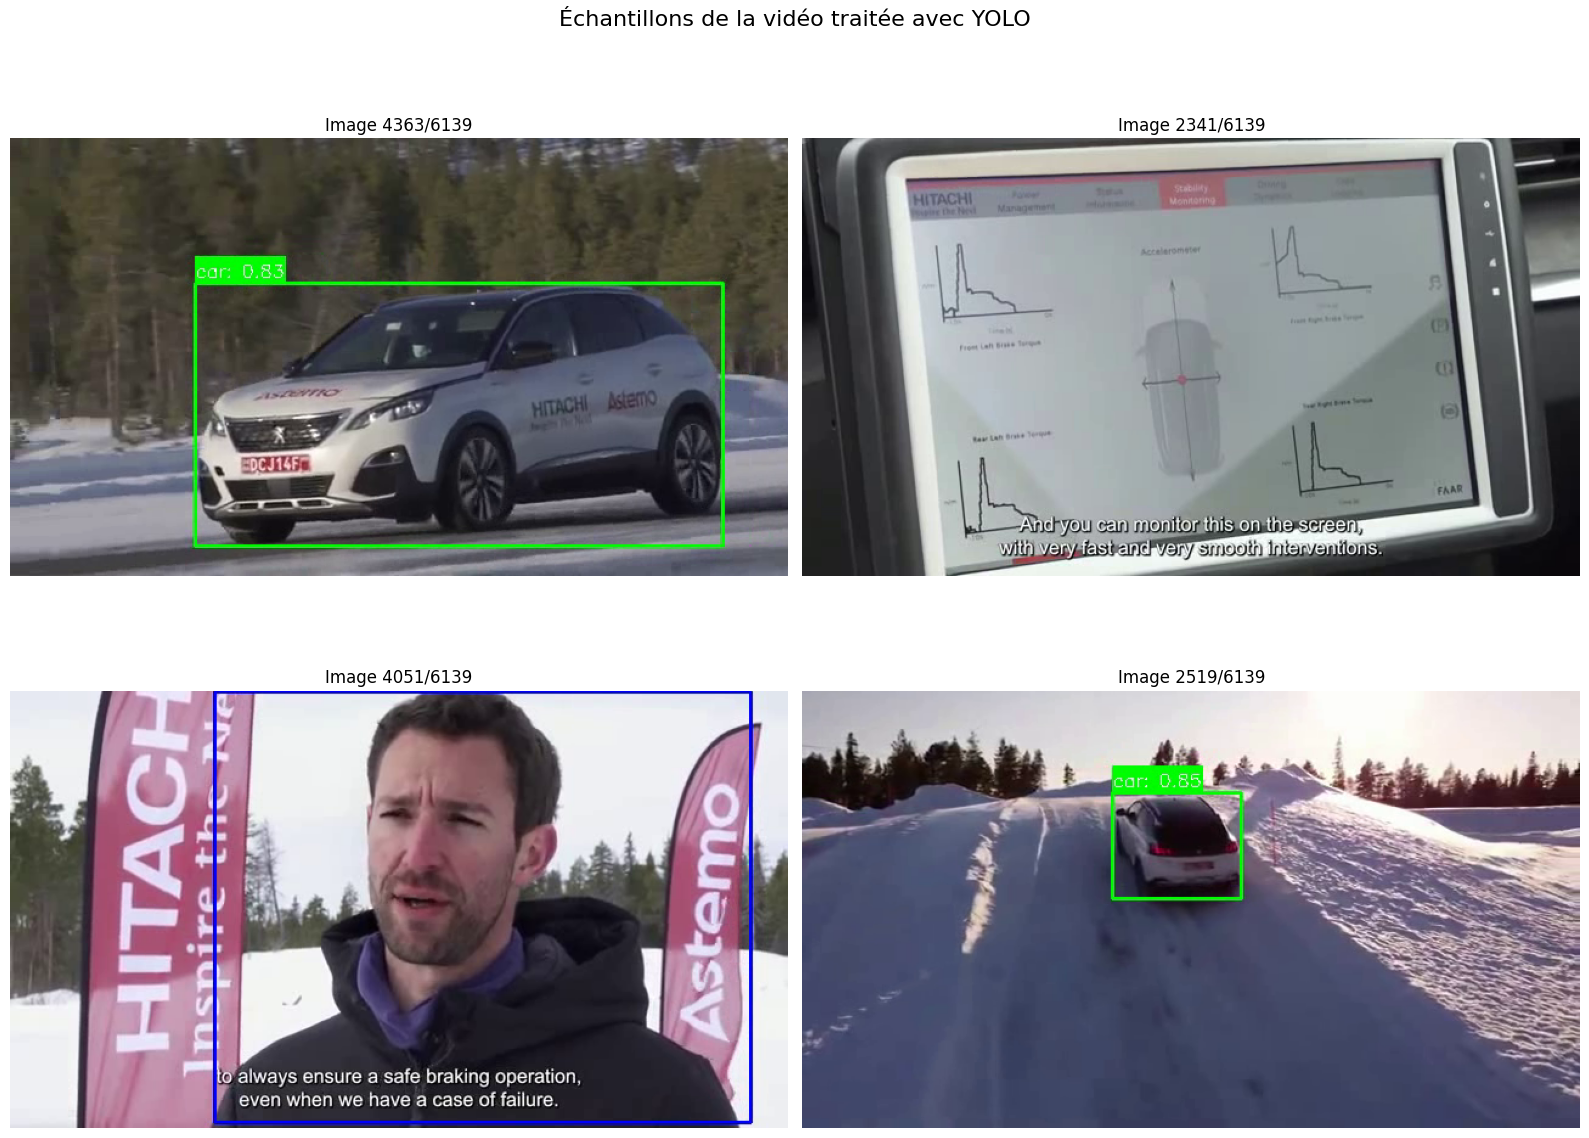

In [19]:
if VIDEO_PATH is not None:
    # Analyser quelques images aléatoirement
    output_path = Path(VIDEO_PATH).parent / f"{Path(VIDEO_PATH).stem}_yolo_detected{Path(VIDEO_PATH).suffix}"
    
    if os.path.exists(output_path):
        cap = cv2.VideoCapture(str(output_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Sélectionner 4 images aléatoirement
        import random
        random_frames = random.sample(range(0, total_frames), min(4, total_frames))
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, frame_num in enumerate(random_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            
            if ret:
                axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                axes[i].set_title(f'Image {frame_num + 1}/{total_frames}')
                axes[i].axis('off')
        
        cap.release()
        plt.tight_layout()
        plt.suptitle('Échantillons de la vidéo traitée avec YOLO', fontsize=16, y=1.02)
        plt.show()
    else:
        print(f"❌ Le fichier de sortie {output_path} n'existe pas.")
else:
    print("⚠️ Aucune vidéo chargée.")

## 9. Configuration avancée (optionnel)

Voici quelques paramètres avancés que vous pouvez modifier.

In [20]:
# Configuration avancée GPU et performance
print("🔧 Configuration avancée disponible:")

print("\n1. Modèles YOLO disponibles:")
models = ['yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt']
for model_name in models:
    speed = "Très rapide" if 'n' in model_name else "Rapide" if 's' in model_name else "Équilibré" if 'm' in model_name else "Lent mais précis" if 'l' in model_name else "Très précis mais lent"
    print(f"   - {model_name}: {speed}")

print("\n2. Classes COCO (quelques exemples):")
common_classes = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 5: 'bus',
    7: 'truck', 9: 'traffic light', 11: 'stop sign', 15: 'cat', 16: 'dog'
}
for class_id, class_name in common_classes.items():
    print(f"   - {class_id}: {class_name}")

print("\n3. Optimisations GPU:")
if DEVICE == 'cuda':
    print("   ✅ GPU activé avec optimisations:")
    print("   - Traitement par batch pour meilleure utilisation GPU")
    print("   - Nettoyage automatique de la mémoire")
    print("   - Fusion des opérations (cudnn.benchmark)")
    print("   - Précision mixte possible (half precision)")
    
    # Afficher l'utilisation mémoire GPU
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated() / (1024**3)
        memory_reserved = torch.cuda.memory_reserved() / (1024**3)
        print(f"   - Mémoire GPU utilisée: {memory_allocated:.2f} GB")
        print(f"   - Mémoire GPU réservée: {memory_reserved:.2f} GB")
else:
    print("   ⚠️ GPU non disponible - optimisations CPU:")
    print("   - Threading pour lecture vidéo")
    print("   - Optimisation mémoire")

print("\n4. Paramètres recommandés:")
print("   - Confiance: 0.3-0.7 (plus bas = plus de détections)")
print("   - IoU: 0.4-0.6 (plus bas = moins de doublons)")
if DEVICE == 'cuda':
    print("   - Batch size: 4-8 pour GPU (selon mémoire disponible)")
    print("   - Modèle: yolov8s ou yolov8m pour bon équilibre vitesse/précision sur GPU")
else:
    print("   - Batch size: 1 pour CPU")
    print("   - Modèle: yolov8n pour vitesse maximale sur CPU")

print("\n5. Conseils de performance:")
if DEVICE == 'cuda':
    print("   🚀 Avec GPU:")
    print("   - Utilisez des modèles plus grands (yolov8m, yolov8l) pour meilleure précision")
    print("   - Augmentez le batch size si vous avez assez de mémoire GPU")
    print("   - Activez la précision mixte pour vitesse supplémentaire")
else:
    print("   💻 Avec CPU:")
    print("   - Utilisez yolov8n pour vitesse maximale")
    print("   - Réduisez la résolution vidéo si nécessaire")
    print("   - Considérez traiter 1 image sur 2 pour vidéos longues")

print("\n✨ Vous pouvez modifier ces paramètres dans les cellules précédentes et relancer le traitement.")

🔧 Configuration avancée disponible:

1. Modèles YOLO disponibles:
   - yolov8n.pt: Très rapide
   - yolov8s.pt: Rapide
   - yolov8m.pt: Équilibré
   - yolov8l.pt: Lent mais précis
   - yolov8x.pt: Lent mais précis

2. Classes COCO (quelques exemples):
   - 0: person
   - 1: bicycle
   - 2: car
   - 3: motorcycle
   - 5: bus
   - 7: truck
   - 9: traffic light
   - 11: stop sign
   - 15: cat
   - 16: dog

3. Optimisations GPU:
   ⚠️ GPU non disponible - optimisations CPU:
   - Threading pour lecture vidéo
   - Optimisation mémoire

4. Paramètres recommandés:
   - Confiance: 0.3-0.7 (plus bas = plus de détections)
   - IoU: 0.4-0.6 (plus bas = moins de doublons)
   - Batch size: 1 pour CPU
   - Modèle: yolov8n pour vitesse maximale sur CPU

5. Conseils de performance:
   💻 Avec CPU:
   - Utilisez yolov8n pour vitesse maximale
   - Réduisez la résolution vidéo si nécessaire
   - Considérez traiter 1 image sur 2 pour vidéos longues

✨ Vous pouvez modifier ces paramètres dans les cellules p

## 10. Nettoyage et conclusion

Nettoyage final et résumé des résultats.

In [21]:
# Nettoyage final
import gc
gc.collect()

print("🧹 Nettoyage terminé.")
print("\n📋 Résumé du laboratoire YOLO:")
print("✅ Modèle YOLO chargé et configuré")
print("✅ Vidéo traitée avec détection d'objets")
print("✅ Annotations ajoutées avec bounding boxes")
print("✅ Vidéo annotée sauvegardée")

if VIDEO_PATH is not None:
    output_path = Path(VIDEO_PATH).parent / f"{Path(VIDEO_PATH).stem}_yolo_detected{Path(VIDEO_PATH).suffix}"
    if os.path.exists(output_path):
        print(f"\n🎯 Votre vidéo traitée est disponible à: {output_path}")
    else:
        print("\n⚠️ La vidéo de sortie n'a pas été créée. Vérifiez les erreurs ci-dessus.")
else:
    print("\n⚠️ N'oubliez pas de spécifier le chemin de votre vidéo dans la cellule 4!")

print("\n🚀 Laboratoire YOLO terminé avec succès!")

🧹 Nettoyage terminé.

📋 Résumé du laboratoire YOLO:
✅ Modèle YOLO chargé et configuré
✅ Vidéo traitée avec détection d'objets
✅ Annotations ajoutées avec bounding boxes
✅ Vidéo annotée sauvegardée

🎯 Votre vidéo traitée est disponible à: ..\IMGs\HitachiAstemoWinterTest_SmartBrakeMovie2022_yolo_detected.mp4

🚀 Laboratoire YOLO terminé avec succès!
